Benchmark-Setup: na=5000, nf=6, nt=150


100%|██████████| 50.0/50.0 [00:22<00:00, 2.20 x10^2 DEM/s]



✅ Baseline runtime: 23.08 s for 5000 DEMs

Running detailed function profiling...


100%|██████████| 2.00/2.00 [00:02<00:00, 1.42s/ x10^2 DEM]


         19742 function calls (19625 primitive calls) in 2.910 seconds

   Ordered by: internal time
   List reduced from 527 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    2.145    1.073    2.145    1.073 {built-in method time.sleep}
       11    0.256    0.023    0.256    0.023 {method 'poll' of 'select.poll' objects}
       11    0.233    0.021    2.635    0.240 /usr/local/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/selectors.py:385(select)
       30    0.099    0.003    2.957    0.099 {method 'control' of 'select.kqueue' objects}
    21/20    0.099    0.005    0.099    0.005 {built-in method posix.write}
        7    0.029    0.004    0.029    0.004 {built-in method posix.waitpid}
        2    0.009    0.004    0.009    0.004 {built-in method _posixsubprocess.fork_exec}
     2165    0.002    0.000    0.004    0.000 /usr/local/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/sit

100%|██████████| 5.00/5.00 [00:03<00:00, 1.66 x10^2 DEM/s]

n=500: 3.12 s



100%|██████████| 10.0/10.0 [00:04<00:00, 2.27 x10^2 DEM/s]

n=1000: 4.61 s



100%|██████████| 20.0/20.0 [00:09<00:00, 2.19 x10^2 DEM/s]


n=2000: 9.48 s


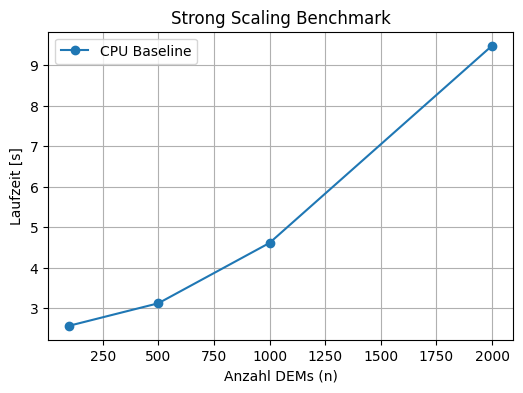

,Version,Runtime [s],Speed-up
0,Baseline (CPU),23.07914,1.0
1,Optimized (Numba),NaN,NaN
2,GPU (CuPy),NaN,NaN


In [4]:
# Benchmark_DEM.ipynb
# ===================
# Performance Analysis Notebook für DEM-Rekonstruktion
# Basierend auf dem Modul "High Performance Computing in Python"

# ---
# Setup
# ---
import numpy as np
import time
import cProfile, pstats
import matplotlib.pyplot as plt

from sys import path as sys_path

sys_path.append('/Users/stefansimic/Documents/HPCP/demreg-hpcp-modul/python')

from demmap_pos import demmap_pos

# ---
# Testdaten erzeugen (skalierbar)
# ---
na = 5000     # Anzahl DEMs (Pixel)
nf = 6        # AIA-Kanäle
nt = 150      # Temperatur-Bins

dd = np.random.random((na, nf)) * 1e3
ed = np.random.random((na, nf)) * 20 + 5
rmatrix = np.random.random((nt, nf)) * 1e-23
logt = np.linspace(5.5, 7.5, nt)
dlogt = np.gradient(logt)
glc = np.ones(nf)
dem_norm0 = np.ones((na, nt))

print(f"Benchmark-Setup: na={na}, nf={nf}, nt={nt}")

# ---
# 1. Baseline-Zeitmessung
# ---
start = time.perf_counter()
dem, edem, elogt, chisq, dn_reg = demmap_pos(dd, ed, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0)
end = time.perf_counter()

baseline_time = end - start
print(f"\n✅ Baseline runtime: {baseline_time:.2f} s for {na} DEMs")

# ---
# 2. Profiling mit cProfile
# ---
print("\nRunning detailed function profiling...")
with cProfile.Profile() as pr:
    demmap_pos(dd[:200], ed[:200], rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0[:200])
stats = pstats.Stats(pr)
stats.sort_stats('tottime').print_stats(10)

# Optional speichern:
# stats.dump_stats("profile_DEM.prof")

# ---
# 3. (Optional) Numba-Optimierung
# ---
try:
    from numba import njit

    @njit
    def dem_inv_gsvd_numba(A, b):
        # Dummy-JIT-Funktion für Beispielzwecke
        return np.linalg.lstsq(A, b, rcond=None)[0]

    # Beispiel: JIT warm-up
    A = np.random.rand(100, 10)
    b = np.random.rand(100)
    dem_inv_gsvd_numba(A, b)

    start = time.perf_counter()
    for _ in range(10):
        dem_inv_gsvd_numba(A, b)
    numba_time = (time.perf_counter() - start) / 10

    print(f"\nNumba test runtime (dummy GSVD): {numba_time:.5f} s")
except ImportError:
    print("Numba not installed – skipping optimization example.")

# ---
# 4. Skalierungstest (verschiedene Eingangsgrößen)
# ---
sizes = [100, 500, 1000, 2000]
times = []

for n in sizes:
    dd_test = np.random.random((n, nf)) * 1e3
    ed_test = np.random.random((n, nf)) * 20 + 5
    dem_norm0_test = np.ones((n, nt))
    
    start = time.perf_counter()
    demmap_pos(dd_test, ed_test, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0_test)
    end = time.perf_counter()
    
    times.append(end - start)
    print(f"n={n}: {end - start:.2f} s")

plt.figure(figsize=(6,4))
plt.plot(sizes, times, 'o-', label="CPU Baseline")
plt.xlabel("Anzahl DEMs (n)")
plt.ylabel("Laufzeit [s]")
plt.title("Strong Scaling Benchmark")
plt.legend()
plt.grid(True)
plt.show()

# ---
# 5. Speed-up-Tabelle (Platzhalter)
# ---
import pandas as pd
data = {
    "Version": ["Baseline (CPU)", "Optimized (Numba)", "GPU (CuPy)"],
    "Runtime [s]": [baseline_time, np.nan, np.nan],
    "Speed-up": [1.0, np.nan, np.nan]
}
df = pd.DataFrame(data)
display(df)